In [11]:
# %%
# open a file as csv without header

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,natsort
import natsort


In [12]:
vary_batchsize_gpus_target_dir = '/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results'
# vary_dataloaders_target_dir = '/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset'


In [13]:
for root, dirs, files in os.walk(vary_batchsize_gpus_target_dir):
    print(root,dirs,files)


/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results ['b256_gpu1', 'b128_gpu1', 'b512_gpu1', 'b1024_gpu2', 'b1024_gpu4', 'b512_gpu2', 'b1024_gpu1', 'b128_gpu4', 'b256_gpu4', 'b1024_gpu3', 'b128_gpu2', 'b256_gpu3', 'b128_gpu3', 'b256_gpu2', 'b512_gpu3', 'b512_gpu4', 'e2e'] []
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b256_gpu1 [] ['custom_log_worker_pid_24952', 'custom_log_main_pid_24869']
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b128_gpu1 [] ['custom_log_worker_pid_137844', 'custom_log_main_pid_137747']
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b512_gpu1 [] ['custom_log_worker_pid_120120', 'custom_log_main_pid_120065']
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b1024_gpu2 [] ['custom_log_main_pid_68741', 'custom_log_worker_pid_68790', 'gpu_idle_times', 'custom_log_worker_pid_68830']
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b1024_gpu4 [] ['cus

In [14]:
def preprocessing_time_summary_vary_batchsize_gpus(target_dir,sort_by='batch_id',fig_size=(50,25),remove_outliers=True,fig_prefix='',fig_dir=''):
    
    root_to_files = {}
    for root, dirs, files in os.walk(target_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    e2e_stat_dir = None
    for root in root_to_files:
        if 'e2e' in root:
            e2e_stat_dir = root

    total_job_elapsed_time = {}
    print("Fetching E2E job time")
    for file in root_to_files[e2e_stat_dir]:

        label = file.split('/')[-1].split('custom_log_')[1].split('.log')[0] # retrieves custom_log_b1024_gpu2.log kind of label
        print(f"{label}:")
        print(os.path.join(e2e_stat_dir, file))
        # read file as csv
        df = pd.read_csv(os.path.join(e2e_stat_dir, file))
        # cast wall(s) column as float type
        df['wall(s)'] = df['wall(s)'].astype(float)
        print(df['wall(s)'][0])
        total_job_elapsed_time[label] = df['wall(s)'][0]
        
    OOO_percentage_combined_df = {}

    total_wait_percentage_combined_df = {}
    for root in roots:
        if 'e2e' in root:
            continue
        print(root)
        files = root_to_files[root]

        OOO_percentage = None
        total_wait = None
        
        for file in files:
            if "main_pid" not in file:
                continue

            df = pd.read_csv(os.path.join(root, file)
                            , header=None)

            # add header
            df.columns = ['name','start_ts','duration']

            # names that start with 'SBatchWait'
            df = df[df['name'].str.startswith('SBatchWait')]
            # map 'SBatchPreprocessed_' such that 'SBatchWait_idx' becomes 'idx' where idx is an integer
            df['batch_id'] = df['name'].map(lambda x: int(x.replace('SBatchWait_','')))

            # total duration of wait time
            total_wait = df["duration"].sum()/1000/1000/1000
            print(f'Total wait time (s): {total_wait}')
            


            # divide by 1000000 to convert from nanoseconds to microseconds
            df['duration'] = df['duration']/1000

            # Total OOO batches (1 microsecond wait time)
            print(f'Total OOO batches: {df[df["duration"]==1].shape[0]}')
            # Total batches
            print(f'total batches: {df.shape[0]}')

            OOO_percentage = df[df["duration"]==1].shape[0] / df.shape[0] * 100


            print(f'OOO percentage: {OOO_percentage}%')
        
        if OOO_percentage is None:
            continue

        label = root.split('/')[-1] # retrieves b128_gpu4 kind of label
        print(f'{label}:')
        OOO_percentage_combined_df[label] = OOO_percentage
        total_wait_percentage_combined_df[label] = total_wait/total_job_elapsed_time[label] * 100


    df = pd.DataFrame.from_dict(OOO_percentage_combined_df,orient='index',columns=['OOO_percentage'])
    # natsort the index
    df = df.reindex(natsort.natsorted(df.index))
    print(df)
    # plot the dataframe
    df.plot(kind='bar')
    # remove legend
    plt.legend().remove()
    # add x and y labels
    plt.xlabel('Configurations')
    plt.ylabel('OOO batches Percentage (%)')
    # put number on top of bars
    for i, v in enumerate(df['OOO_percentage']):
        plt.text(i, v + 0.5, str(round(v,2)), ha='center')
    plt.show()

    df = pd.DataFrame.from_dict(total_wait_percentage_combined_df,orient='index',columns=['stall_percentage'])
    # natsort the index
    df = df.reindex(natsort.natsorted(df.index))
    print(df)
    # plot the dataframe
    df.plot(kind='bar',figsize=(10,3))
    # remove legend
    plt.legend().remove()
    # add x and y labels
    plt.xlabel('Configurations')
    plt.ylabel('E2E Stall (%)')
    # put number on top of bars
    for i, v in enumerate(df['stall_percentage']):
        plt.text(i, v + 0.5, str(round(v,2)), ha='center')
    plt.show()

    return


Fetching E2E job time
b128_gpu2:
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/e2e/custom_log_b128_gpu2.log
12856.16
b512_gpu1:
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/e2e/custom_log_b512_gpu1.log
12856.16
b1024_gpu4:
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/e2e/custom_log_b1024_gpu4.log
5804.34
b512_gpu2:
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/e2e/custom_log_b512_gpu2.log
12545.4
b1024_gpu2:
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/e2e/custom_log_b1024_gpu2.log
12652.49
b512_gpu4:
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/e2e/custom_log_b512_gpu4.log
5802.83
b512_gpu3:
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/e2e/custom_log_b512_gpu3.log
8028.14
b128_gpu1:
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/e2e/custom_log_b128_gpu1.log
12856.16
b256_gpu1:
/home/mayurpl/sem_2/special_pro

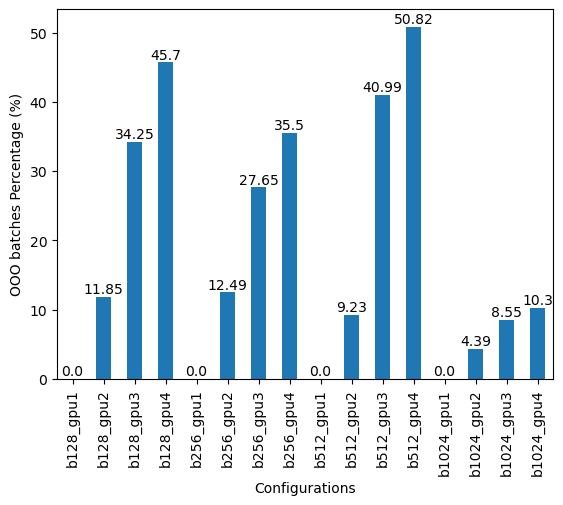

            stall_percentage
b128_gpu1         171.199645
b128_gpu2          84.391026
b128_gpu3          82.091409
b128_gpu4          80.858597
b256_gpu1         168.501529
b256_gpu2          82.585958
b256_gpu3          82.728219
b256_gpu4          78.813116
b512_gpu1         165.041574
b512_gpu2          84.370354
b512_gpu3          80.047423
b512_gpu4          79.795513
b1024_gpu1        166.927272
b1024_gpu2         82.904857
b1024_gpu3         79.229993
b1024_gpu4         81.173250


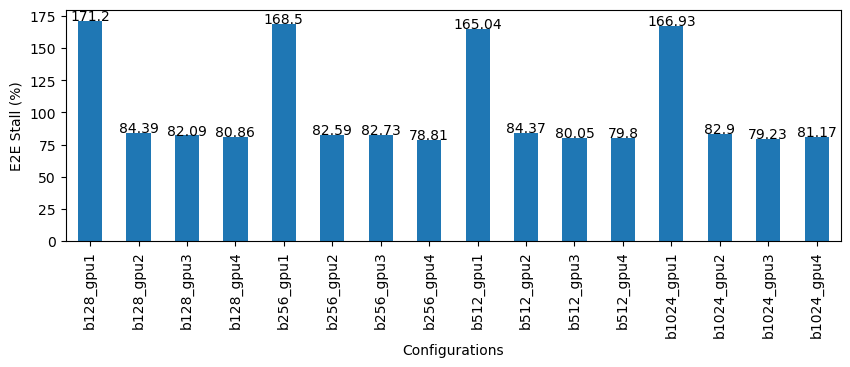

In [15]:
preprocessing_time_summary_vary_batchsize_gpus(vary_batchsize_gpus_target_dir)

In [16]:
def preprocessing_time_summary_vary_dataloaders(target_dir,sort_by='batch_id',fig_size=(50,25),remove_outliers=True,fig_prefix='',fig_dir=''):
    
    root_to_files = {}
    for root, dirs, files in os.walk(target_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    e2e_stat_dir = None
    for root in root_to_files:
        if 'e2e' in root:
            e2e_stat_dir = root

    total_job_elapsed_time = {}
    print("Fetching E2E job time")
    for file in root_to_files[e2e_stat_dir]:

        label = file.split('/')[-1].split('custom_log_')[1].split('.log')[0] # retrieves custom_log_b1024_gpu2.log kind of label
        print(f"{label}:")
        print(os.path.join(e2e_stat_dir, file))
        # read file as csv
        df = pd.read_csv(os.path.join(e2e_stat_dir, file),nrows=3)
        # cast wall(s) column as float type
        df['Metric Value'] = df['Metric Value'].astype(float)
        job_elapsed_time = df[df["Metric Name"]=="Elapsed Time"]["Metric Value"][0]
        print(f"Elapsed Time(s): {job_elapsed_time}")
        total_job_elapsed_time[label] = job_elapsed_time
        
    OOO_percentage_combined_df = {}

    total_wait_percentage_combined_df = {}
    for root in roots:
        if 'e2e' in root:
            continue
        print(root)
        files = root_to_files[root]

        OOO_percentage = None
        total_wait = None
        
        for file in files:
            if "main_pid" not in file:
                continue

            df = pd.read_csv(os.path.join(root, file)
                            , header=None)

            # add header
            df.columns = ['name','start_ts','duration']

            # names that start with 'SBatchWait'
            df = df[df['name'].str.startswith('SBatchWait')]
            # map 'SBatchPreprocessed_' such that 'SBatchWait_idx' becomes 'idx' where idx is an integer
            df['batch_id'] = df['name'].map(lambda x: int(x.replace('SBatchWait_','')))

            # total duration of wait time
            total_wait = df["duration"].sum()/1000/1000/1000
            print(f'Total wait time (s): {total_wait}')
            


            # divide by 1000000 to convert from nanoseconds to microseconds
            df['duration'] = df['duration']/1000

            # Total OOO batches (1 microsecond wait time)
            print(f'Total OOO batches: {df[df["duration"]==1].shape[0]}')
            # Total batches
            print(f'total batches: {df.shape[0]}')

            OOO_percentage = df[df["duration"]==1].shape[0] / df.shape[0] * 100


            print(f'OOO percentage: {OOO_percentage}%')
        
        if OOO_percentage is None:
            continue

        label = root.split('/')[-1] # retrieves b128_gpu4 kind of label
        print(f'{label}:')
        OOO_percentage_combined_df[label] = OOO_percentage
        total_wait_percentage_combined_df[label] = total_wait/total_job_elapsed_time[label] * 100


    df = pd.DataFrame.from_dict(OOO_percentage_combined_df,orient='index',columns=['OOO_percentage'])
    # natsort the index
    df = df.reindex(natsort.natsorted(df.index))
    print(df)
    # plot the dataframe
    df.plot(kind='bar')
    # remove legend
    plt.legend().remove()
    # add x and y labels
    plt.xlabel('Configurations')
    plt.ylabel('OOO batches Percentage (%)')
    # put number on top of bars
    for i, v in enumerate(df['OOO_percentage']):
        plt.text(i, v + 0.5, str(round(v,2)), ha='center')
    plt.show()

    df = pd.DataFrame.from_dict(total_wait_percentage_combined_df,orient='index',columns=['stall_percentage'])
    # natsort the index
    df = df.reindex(natsort.natsorted(df.index))
    print(df)
    # plot the dataframe
    df.plot(kind='bar')
    # remove legend
    plt.legend().remove()
    # add x and y labels
    plt.xlabel('Configurations')
    plt.ylabel('E2E Stall (%)')
    # put number on top of bars
    for i, v in enumerate(df['stall_percentage']):
        plt.text(i, v + 0.5, str(round(v,2)), ha='center')
    plt.show()

    return


In [17]:
preprocessing_time_summary_vary_dataloaders(vary_dataloaders_target_dir)

NameError: name 'vary_dataloaders_target_dir' is not defined